In [1]:
import os, csv
from pathlib import Path
import pandas as pd
import nibabel as nib
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import nilearn.plotting
from IPython.display import display, clear_output
from ipywidgets import widgets, interact
import numpy as np
import regtricks as rt
from nibabel import nifti1
from PIL import Image
from nibabel.viewers import OrthoSlicer3D
from nilearn import datasets, surface
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import OneClassSVM
import math
%matplotlib widget

In [2]:
work_space = r'D:\onedrive\OneDrive - The University of Nottingham\thesis\QC_report'

In [3]:
def load_signal_csv():
    signal_path = os.path.join(work_space, 'signal.csv')
    signal_df = pd.read_csv(signal_path)
    snr = signal_df['SNR'].to_numpy()
    cnr = signal_df['CNR'].to_numpy()
    tsnr = signal_df['tSNR'].to_numpy()
    tcnr = signal_df['tCNR'].to_numpy()
    signal_dict = {}
    signal_dict['snr'] = snr
    signal_dict['cnr'] = cnr
    signal_dict['tsnr'] = tsnr
    signal_dict['tcnr'] = tcnr
    signal_dict['subject'] = signal_df['subject'].to_numpy()
    #print()
    return signal_dict

In [4]:
signal_dict = load_signal_csv()
for signal in ['snr', 'cnr', 'tsnr', 'tcnr']:
    signal_dict[signal] = signal_dict[signal]/max(signal_dict[signal])


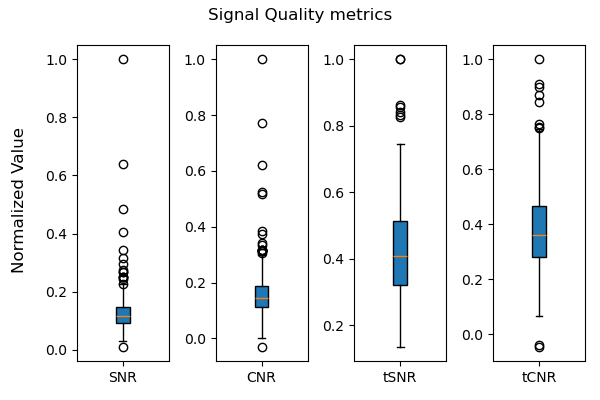

interactive(children=(Dropdown(description='Metric:', options=(('SNR', 'snr'), ('CNR', 'cnr'), ('TSNR', 'tsnr'…

In [5]:
current_metric = 'snr'
upper_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=1, description="Max")
lower_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=0, description="Min")

fig, axs = plt.subplots(1, 4, figsize=(6,4), sharey=False, tight_layout=True)

axs[0].boxplot(signal_dict['snr'], patch_artist=True, labels=['SNR'])
axs[1].boxplot(signal_dict['cnr'], patch_artist=True, labels=['CNR'])
axs[2].boxplot(signal_dict['tsnr'], patch_artist=True, labels=['tSNR'])
axs[3].boxplot(signal_dict['tcnr'], patch_artist=True, labels=['tCNR'])

fig.supylabel('Normalized Value')
fig.suptitle('Signal Quality metrics')
plt.show()


signal_options = [('SNR', 'snr'), ('CNR', 'cnr'),('TSNR', 'tsnr'),('TCNR', 'tcnr')]
signal_dropdown = ipywidgets.Dropdown(options=signal_options,
                                value=current_metric,
                                description="Metric:")


text_area = ipywidgets.Textarea(
    #value='Hello World',
    #placeholder='Outeliers',
    description='Outliers:',
    rows=10,
    disabled=False
)

def show_subject(signal_metric, h_thres, l_thres, output, fig):
   

    
    try:
        outliers = []

        for idx, value in enumerate(signal_dict[signal_metric]):
            if value > h_thres or value < l_thres:
                outliers.append(signal_dict['subject'][idx])

        s = '\n'.join(outliers)
        text_area.value = s
        #print(s)
        
    
    except Exception as e:
        print(str(e))
        
_ = interact(show_subject,
             signal_metric=signal_dropdown,
             h_thres = upper_threshold,
             l_thres = lower_threshold,
             output=text_area,
             fig=ipywidgets.fixed(fig)
            )

In [6]:
oxasl_results_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\oxasl_vol'
nonpvc_path = os.path.join(oxasl_results_path, 'nonpvc')
pvc_path = os.path.join(oxasl_results_path, 'pvc')

In [7]:
def obtain_region_analysis(subject):
    
    #subj_path = os.path.join(data_path, subject)
    assert subject, 'path is empty'
    subj_id = subject[-7:]
    #assert subj_path[:3] == 'sub', 'path is not included'

    roi_path = os.path.join(nonpvc_path, 'roi_stats_{}.csv'.format(subj_id))
    roi_gm_path = os.path.join(pvc_path, 'roi_stats_gm_{}.csv'.format(subj_id))
    roi_wm_path = os.path.join(pvc_path, 'roi_stats_wm_{}.csv'.format(subj_id))

    perfusion_df = pd.read_csv(roi_path)
    perfusion_gm_df = pd.read_csv(roi_gm_path)
    perfusion_wm_df = pd.read_csv(roi_wm_path)


    perfusion_df['name'].replace('80%+GM', 'GM', inplace=True)
    perfusion_df['name'].replace('90%+WM', 'WM', inplace=True)
    perfusion_df['name'].replace('Right_Cerebral_White_Matter_80%+', 'RCWM', inplace=True)
    perfusion_df['name'].replace('Left_Cerebral_White_Matter_80%+', 'LCWM', inplace=True)
    perfusion_gm_df['name'].replace('80%+GM', 'GM', inplace=True)
    perfusion_wm_df['name'].replace('90%+WM', 'WM', inplace=True)
    perfusion_wm_df['name'].replace('Right_Cerebral_White_Matter_80%+', 'RCWM', inplace=True)
    perfusion_wm_df['name'].replace('Left_Cerebral_White_Matter_80%+', 'LCWM', inplace=True)

    
    roi_names = ['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']
    roi_gm_names = ['GM', 'VBA', 'RICA', 'LICA']
    roi_wm_names = ['WM', 'RCWM', 'LCWM',]

    roi_indices = perfusion_df.index[perfusion_df['name'].isin(roi_names)].tolist()
    roi_gm_indices = perfusion_gm_df.index[perfusion_gm_df['name'].isin(roi_gm_names)].tolist()
    roi_wm_indices = perfusion_wm_df.index[perfusion_wm_df['name'].isin(roi_wm_names)].tolist()


    roi_stats_df = perfusion_df.iloc[roi_indices].reset_index(drop=True)
    roi_gm_stats_df = perfusion_gm_df.iloc[roi_gm_indices]
    roi_wm_stats_df = perfusion_wm_df.iloc[roi_wm_indices]
    roi_pvc_stats_df = pd.concat([roi_gm_stats_df, roi_wm_stats_df], axis=0).reset_index(drop=True)
    #roi_pvc_stats_df = roi_pvc_stats_df.reset_index(drop=True)

    roi_stats = {}
    roi_stats['nonpvc'] = roi_stats_df
    roi_stats['pvc'] = roi_pvc_stats_df

    for perf in roi_stats.values():
        perf['SpCov'] = perf[['Std', 'Mean']].apply(lambda x: x['Std'] * 100 / x['Mean'], axis=1).round(2)

    #print(roi_stats)
    return roi_stats

In [8]:
perfusion_dict = {}

for subj in signal_dict['subject']:
    perfusion_results = obtain_region_analysis(subj)
    perfusion_dict[subj] = perfusion_results
    #print(perfusion_results)
    #break

In [9]:
cbf_nonpvc_roi_dict = {}
cbf_pvc_roi_dict = {}

spcov_nonpvc_roi_dict = {}
spcov_pvc_roi_dict = {}

subjects_list = []
for subj in perfusion_dict.keys():
    subjects_list.append(subj)
    for pvc in ['nonpvc', 'pvc']:

        rois = perfusion_dict[subj][pvc].name.to_numpy()
        temp_df = perfusion_dict[subj][pvc]
        if pvc == 'nonpvc':
            for roi in rois:
                if roi not in cbf_nonpvc_roi_dict.keys():
                    cbf_nonpvc_roi_dict[roi] = []
                    spcov_nonpvc_roi_dict[roi] = []
                
                temp_cbf = temp_df[temp_df.name == roi].Mean.to_numpy()[0]
                temp_spcov = temp_df[temp_df.name == roi].SpCov.to_numpy()[0]
                if not math.isnan(temp_cbf):
                    cbf_nonpvc_roi_dict[roi].append(temp_cbf)
                if not math.isnan(temp_spcov):
                    spcov_nonpvc_roi_dict[roi].append(temp_spcov)
        else:
            for roi in rois:
                if roi not in cbf_pvc_roi_dict.keys():
                    cbf_pvc_roi_dict[roi] = []
                    spcov_pvc_roi_dict[roi] = []

                temp_cbf = temp_df[temp_df.name == roi].Mean.to_numpy()[0]
                temp_spcov = temp_df[temp_df.name == roi].SpCov.to_numpy()[0]
                if not math.isnan(temp_cbf):
                    cbf_pvc_roi_dict[roi].append(temp_cbf)
                if not math.isnan(temp_spcov):
                    spcov_pvc_roi_dict[roi].append(temp_spcov)

#print((cbf_pvc_roi_dict['VBA']))
#print(len(subjects_list))


In [10]:
#['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']
current_metric = 'GM'
#if current_metric in  ['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']:
upper_threshold = ipywidgets.widgets.IntSlider(min=0, max=100, step=1, value=100, description="Max")
lower_threshold = ipywidgets.widgets.IntSlider(min=0, max=100, step=1, value=0, description="Min")
#upper_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=1, description="Upper threshold")
#lower_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=0, description="Lower threshold")

#fig, axs = plt.subplots(1, 3, figsize=(6,4), sharey=False, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
#labels=['non-PVEc', 'PVEc']

metric_options = [('GM', 'GM'), ('WM', 'WM'),  ('LCWM', 'LCWM'), ('RCWM', 'RCWM'), ('LICA', 'LICA'), ('RICA', 'RICA'), ('VBA', 'VBA')]
metric_dropdown = ipywidgets.Dropdown(options=metric_options,
                                value=current_metric,
                                description="Metric:")

PVC_options = [("No", 'nonpvc'),('Yes', 'pvc')]
PVC_dropdown = ipywidgets.Dropdown(options=PVC_options,
                                value='nonpvc',
                                description="PVC:")


text_area = ipywidgets.Textarea(
    #value='Hello World',
    #placeholder='Outeliers',
    description='Outliers:',
    rows=10,
    disabled=False
)

def show_subject(pvc, metric, h_thres, l_thres, output):
    
    try:
    
        if pvc == 'nonpvc':
            data = cbf_nonpvc_roi_dict
            title = 'Non-PVEc CBF'
        else:
            data = cbf_pvc_roi_dict
            title = 'PVEc CBF'


        fig, axs = plt.subplots(1, 3, figsize=(7,4), sharey=False, tight_layout=True)  
        axs[0].boxplot([data['GM'], data['WM']], patch_artist=True, labels=['GM', 'WM'])
        axs[1].boxplot([data['LCWM'], data['RCWM']], patch_artist=True, labels=['LCWM', 'RCWM'])
        axs[2].boxplot([data['LICA'], data['RICA'], data['VBA']], patch_artist=True, labels=['LICA', 'RICA', 'VBA'])
        #print(len(data['RICA']), len(data['VBA']))
        
        axs[0].set_title('GM and WM')
        axs[1].set_title('Cerebral White Matter')
        axs[2].set_title('Vascular Territories')
        axs[0].set_ylabel('CBF(ml/100g/min)')
        #axs[1].set_ylabel('CBF(ml/100g/min)')
        #axs[2].set_ylabel('CBF(ml/100g/min)')
        
        fig.suptitle(title)
          
        plt.show()
        
        outliers = []
      
        #print(metric)
        for idx, subj in enumerate(subjects_list):
            #print(cbf_nonpvc_roi_dict[roi][idx])
            value = data[metric][idx]
            
            if value > h_thres or value < l_thres:
                print(idx, value)
                outliers.append(subj)

        s = '\n'.join(outliers)
        text_area.value = s
        #print(s)
        
    
    except Exception as e:
        print(str(e))
        
_ = interact(show_subject,
             pvc=PVC_dropdown,
             metric=metric_options,
             h_thres = upper_threshold,
             l_thres = lower_threshold,
             output=text_area,
             #fig=ipywidgets.fixed(fig),
             #axs=axs,
            )

interactive(children=(Dropdown(description='PVC:', options=(('No', 'nonpvc'), ('Yes', 'pvc')), value='nonpvc')…

In [11]:
#['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']
current_metric = 'GM'
#if current_metric in  ['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']:
upper_threshold = ipywidgets.widgets.IntSlider(min=0, max=400, step=1, value=400, description="Max")
lower_threshold = ipywidgets.widgets.IntSlider(min=0, max=100, step=1, value=0, description="Min")
#upper_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=1, description="Upper threshold")
#lower_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=0, description="Lower threshold")

#fig, axs = plt.subplots(1, 3, figsize=(6,4), sharey=False, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
#labels=['non-PVEc', 'PVEc']




metric_options = [('GM', 'GM'), ('WM', 'WM'),  ('LCWM', 'LCWM'), ('RCWM', 'RCWM'), ('LICA', 'LICA'), ('RICA', 'RICA'), ('VBA', 'VBA')]
metric_dropdown = ipywidgets.Dropdown(options=metric_options,
                                value=current_metric,
                                description="Metric:")

PVC_options = [("No", 'nonpvc'),('Yes', 'pvc')]
PVC_dropdown = ipywidgets.Dropdown(options=PVC_options,
                                value='nonpvc',
                                description="PVC:")


text_area = ipywidgets.Textarea(
    #value='Hello World',
    #placeholder='Outeliers',
    description='Outliers:',
    rows=10,
    disabled=False
)

def show_subject(metric, pvc, h_thres, l_thres, output):
    
    try:
        
        if pvc == 'nonpvc':
            data = spcov_nonpvc_roi_dict
            title = 'Spatial Coefficient of Variation in Non-PVEc CBF '
        else:
            data = spcov_pvc_roi_dict
            title = 'Spatial Coefficient of Variation in PVEc CBF '

        fig, axs = plt.subplots(1, 3, figsize=(7,4), sharey=False, tight_layout=True)  
        axs[0].boxplot([data['GM'], data['WM']], patch_artist=True, labels=['GM', 'WM'])
        axs[1].boxplot([data['LCWM'], data['RCWM']], patch_artist=True, labels=['LCWM', 'RCWM'])
        axs[2].boxplot([data['LICA'], data['RICA'], data['VBA']], patch_artist=True, labels=['LICA', 'RICA', 'VBA'])
        #print(len(data['RICA']), len(data['VBA']))
        
        axs[0].set_title('GM and WM')
        axs[1].set_title('Cerebral White Matter')
        axs[2].set_title('Vascular Territories')
        axs[0].set_ylabel('SpCoV')
        #axs[1].set_ylabel('CBF(ml/100g/min)')
        #axs[2].set_ylabel('CBF(ml/100g/min)')
        fig.suptitle(title)
          
        plt.show()

        outliers = []
      
        #print(metric)
        for idx, subj in enumerate(subjects_list):
            #print(cbf_nonpvc_roi_dict[roi][idx])
            value = data[metric][idx]
            
            if value > h_thres or value < l_thres:
                print(idx, value)
                outliers.append(subj)

        s = '\n'.join(outliers)
        text_area.value = s
        #print(s)
        
    
    except Exception as e:
        print(str(e))
        
_ = interact(show_subject,
             metric=metric_options,
             pvc=PVC_dropdown,
             h_thres = upper_threshold,
             l_thres = lower_threshold,
             output=text_area,
             #fig=ipywidgets.fixed(fig),
             #axs=axs,
            )

interactive(children=(Dropdown(description='metric', options=(('GM', 'GM'), ('WM', 'WM'), ('LCWM', 'LCWM'), ('…

In [12]:
def load_regcor_csv():
    regcor_path = os.path.join(work_space, 'correlation.csv')
    regcor_df = pd.read_csv(regcor_path)
    mse = regcor_df['mse'].to_numpy()
    cc = regcor_df['cc'].to_numpy()
    #pcc = regcor_df['pcc'].to_numpy()
    mi = regcor_df['mi'].to_numpy()
    nmi = regcor_df['nmi'].to_numpy()
    cr = regcor_df['cr'].to_numpy()
    
    regcor_dict = {}
    regcor_dict['mse'] = mse
    regcor_dict['cc'] = cc
    #regcor_dict['pcc'] = pcc
    regcor_dict['mi'] = mi
    regcor_dict['nmi'] = nmi
    regcor_dict['cr'] = cr
    
    regcor_dict['subject'] = regcor_df['subject'].to_numpy()
    #print()
    return regcor_dict

In [13]:
reg_cor_dict = load_regcor_csv()
for metric in ['mse', 'cr', 'cc', 'mi', 'nmi']:
    reg_cor_dict[metric] = reg_cor_dict[metric]/max(reg_cor_dict[metric])

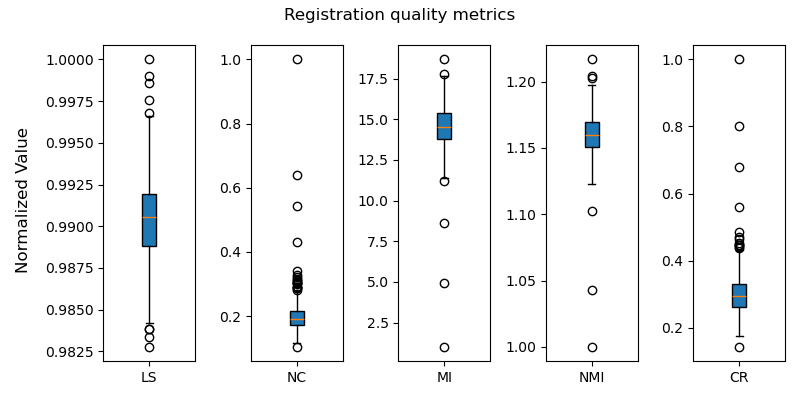

interactive(children=(Dropdown(description='Metric:', options=(('Least Square', 'mse'), ('Norm Correlation', '…

In [14]:


current_metric = 'mse'
upper_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=1, description="Max")
lower_threshold = ipywidgets.widgets.FloatSlider(min=0, max=1, step=0.01, value=0, description="Min")

fig, axs = plt.subplots(1, 5, figsize=(8, 4), sharey=False, tight_layout=True)

#comb = [reg_cor_dict['cc'], reg_cor_dict['pcc'], reg_cor_dict['mi'], reg_cor_dict['nmi'],reg_cor_dict['cr'] ]
reg_labels = ['LS', 'NC', 'MI', 'NMI', 'CR']

axs[0].boxplot(reg_cor_dict['mse'], patch_artist=True, labels=['LS'])
axs[1].boxplot(reg_cor_dict['cc'],  patch_artist=True,labels=['NC'])
axs[2].boxplot(reg_cor_dict['mi'], patch_artist=True, labels=['MI'])
axs[3].boxplot(reg_cor_dict['nmi'], patch_artist=True, labels=['NMI'])
axs[4].boxplot(reg_cor_dict['cr'], patch_artist=True, labels=['CR'])

#axs[0, 1].boxplot([nonpvc_spcov_list, pvc_spcov_list], patch_artist=True, labels=labels)

#axs[1,1].set_title('tCNR')
#axs[1,0].set_title('tSNR')
#axs[0,1].set_title('CNR')
#axs[0,0].set_title('SNR')
#fig.supylabel('Signal Intensity')
fig.supylabel('Normalized Value')
fig.suptitle('Registration quality metrics')

plt.show()


metric_options = [('Least Square', 'mse'), ('Norm Correlation', 'cc'),('Mutual Inforamtion', 'mi'),('Norm Mutual Information', 'nmi'),('Correlation Ratio', 'cr')]
metric_dropdown = ipywidgets.Dropdown(options=metric_options,
                                value=current_metric,
                                description="Metric:")


text_area = ipywidgets.Textarea(
    #value='Hello World',
    #placeholder='Outeliers',
    description='Outliers:',
    rows=10,
    disabled=False
)

def show_subject(metric, h_thres, l_thres, output, fig):
   

    
    try:
        outliers = []

        for idx, value in enumerate(reg_cor_dict[metric]):
            if value > h_thres or value < l_thres:
                outliers.append(reg_cor_dict['subject'][idx])

        s = '\n'.join(outliers)
        text_area.value = s
        #print(s)
        
    
    except Exception as e:
        print(str(e))
        
_ = interact(show_subject,
             metric=metric_dropdown,
             h_thres = upper_threshold,
             l_thres = lower_threshold,
             output=text_area,
             fig=ipywidgets.fixed(fig)
            )